## Time series ML Model

In [191]:
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
color_pal = sb.color_palette()
plt.style.use('fivethirtyeight')

In [192]:
## import data and change datetime type to datetime
data = pd.read_csv("AEP_hourly.csv")
data = data.set_index('Datetime')
data.index = pd.to_datetime(data.index)

<Axes: title={'center': 'Energy use in MW'}, xlabel='Datetime'>

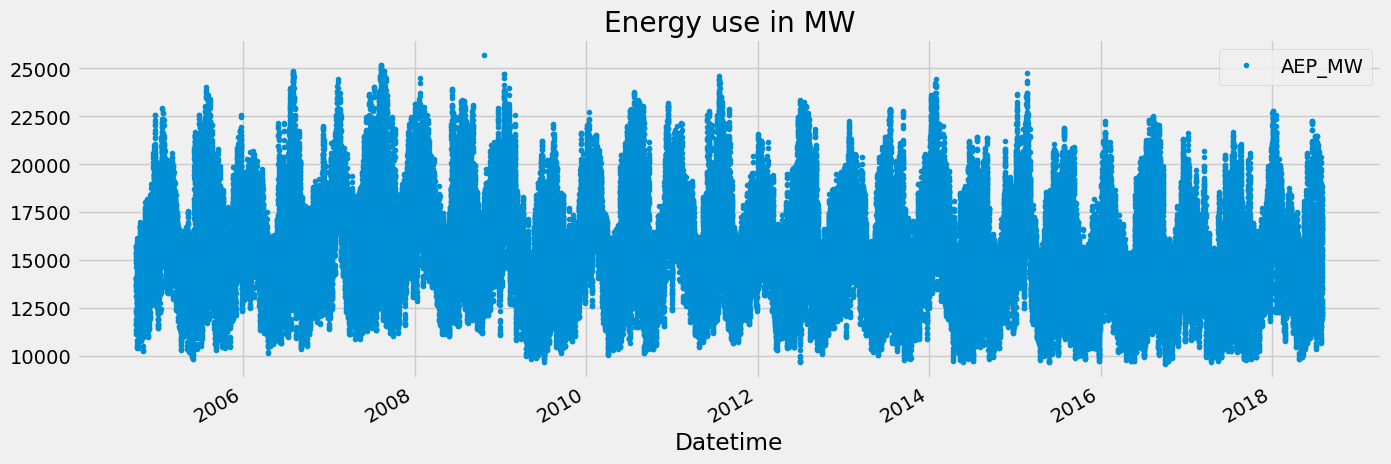

In [193]:
data.plot(style=".", 
          figsize=(15,5), 
          color = color_pal[0], 
          title="Energy use in MW")

## Split Data into train and Test

In [194]:
train = data.loc[data.index < '01-01-2015']
test = data.loc[data.index >= '01-01-2015']

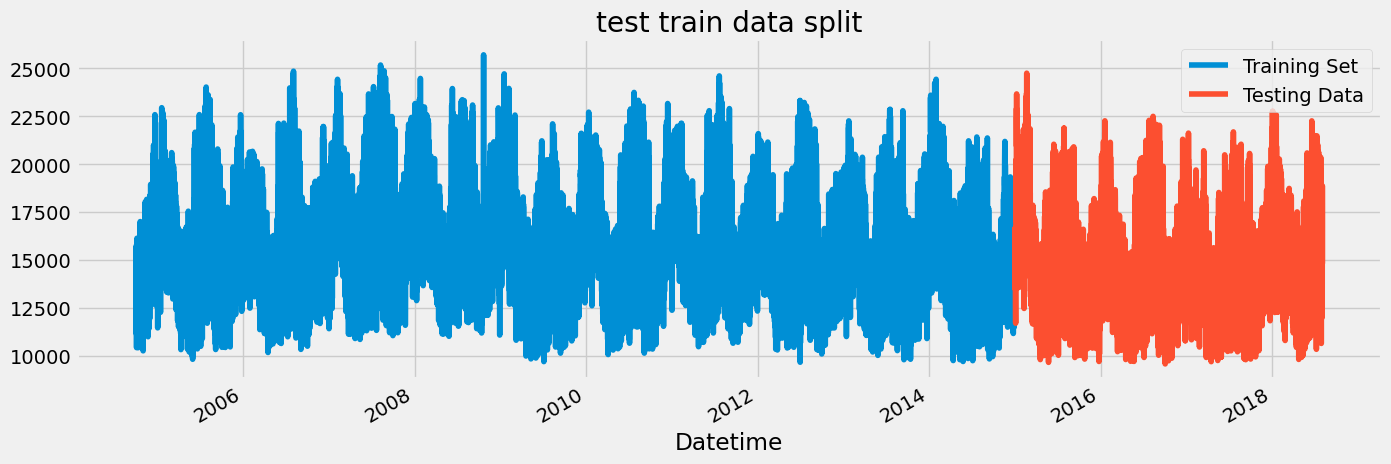

In [195]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label = 'train data', title='test train data split')
test.plot(ax=ax, label = 'test data')
ax.legend(['Training Set', 'Testing Data'])

## lets look at one week of data

<Axes: xlabel='Datetime'>

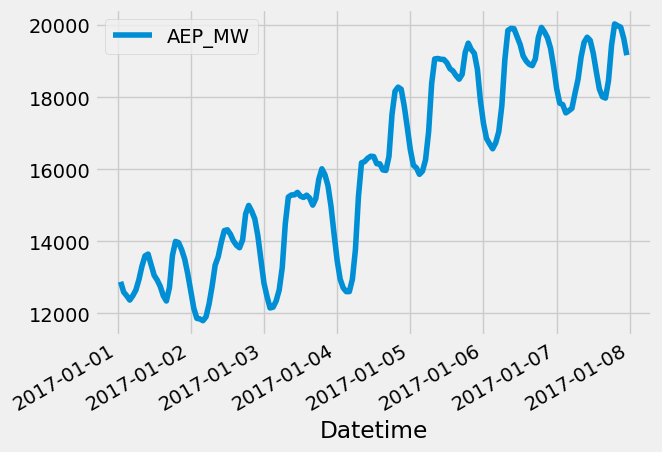

In [196]:
weekData = data.loc[(data.index > "01-01-2017") & (data.index < '01-08-2017')]
weekData.plot()

## Creating Features

In [197]:
def add_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = add_features(data)

In [198]:
data = add_features(data)
data

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,1
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,1
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,1


## look at features versus usage

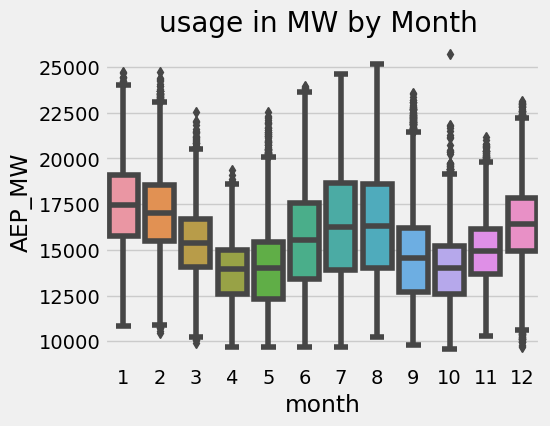

In [199]:
fig, ax = plt.subplots(figsize=(5,4))
sb.boxplot(data=data, x = 'month', y ='AEP_MW')
ax.set_title("usage in MW by Month ")
plt.show()

## Create Model 

In [200]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [203]:
regModel = xgb.XGBRegressor(n_estimators = 1000, 
                            early_stopping_rounds=50, 
                           learning_rate=0.01)
regModel.fit(X_train, y_train, 
            eval_set = [(X_train, y_train), (X_test, y_test)], 
            verbose = 100)

[0]	validation_0-rmse:15792.50936	validation_1-rmse:14861.30366
[100]	validation_0-rmse:5946.79524	validation_1-rmse:5178.51130
[200]	validation_0-rmse:2508.81795	validation_1-rmse:2125.27097
[300]	validation_0-rmse:1473.11711	validation_1-rmse:1578.02598
[383]	validation_0-rmse:1227.05917	validation_1-rmse:1577.68315


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

 ## feature importances

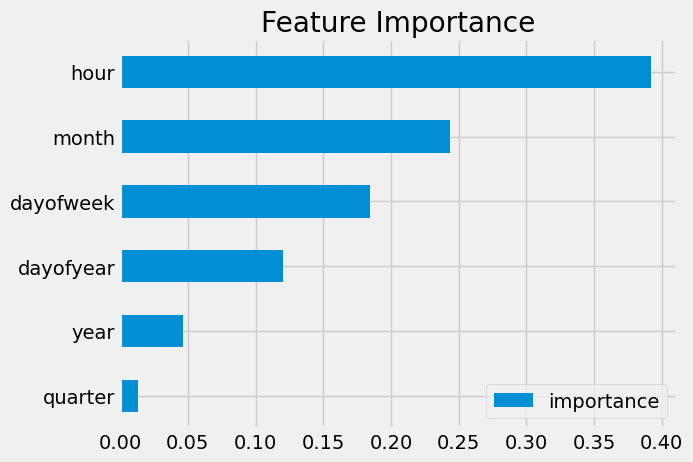

In [204]:
importance = pd.DataFrame(data=regModel.feature_importances_,
             index=regModel.feature_names_in_,
             columns=['importance'])
importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

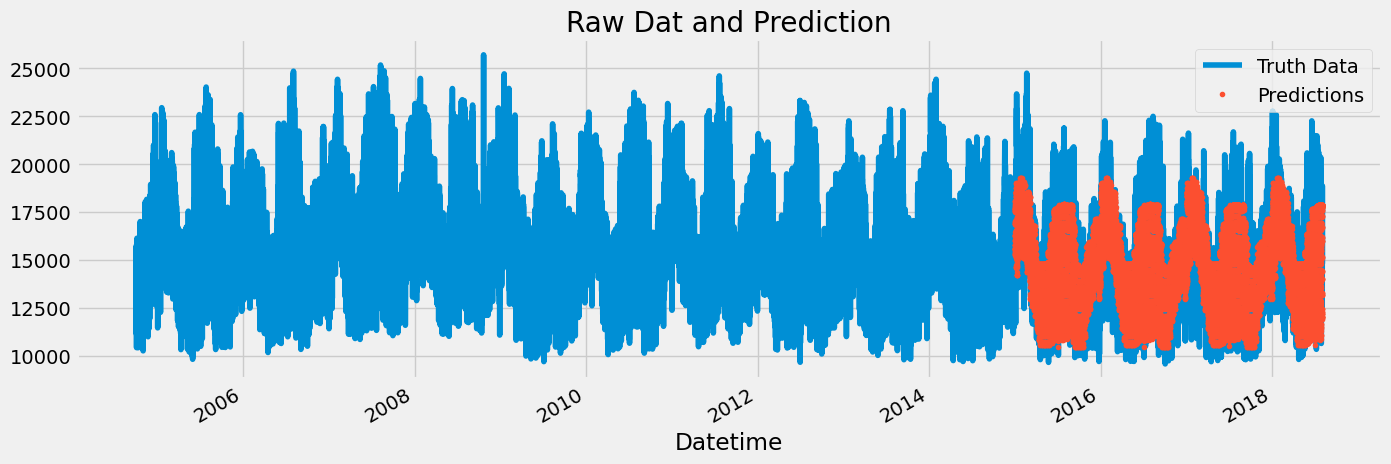

In [205]:
test['prediction'] = regModel.predict(X_test)
data = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = data[['AEP_MW']].plot(figsize=(15, 5))
data['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [206]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1564.08


## Error 

In [208]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-20    5444.133748
2015-02-19    5358.522949
2018-01-06    5089.786051
2018-01-07    4698.032756
2017-12-31    4365.473267
2015-02-16    4330.623535
2017-01-22    4145.269287
2015-01-08    4061.021973
2017-12-28    3999.065592
2017-01-08    3937.605265
Name: error, dtype: float64

# Next Steps
- try to add extra features such as temperature at time of day
- try to add if the day is a holiday 
-  try more robust cross validation 